In [1]:
import geopandas as gpd
import pandas as pd
#import geoplot as gplt
import laspy
import shapely
import os
from datetime import datetime
import numpy as np
from itertools import product
import math
import pyproj
import re
import pyspark

In [2]:
resolution = 100  #grid resolution in meters
outPath = f"{os.curdir}{os.sep}output{os.sep}"
outputFileName = f"{outPath}AggLidarData_UpperDelta_{resolution}m.pickle"
#captureHoods = ['GENTILLY TERRACE','GENTILLY WOODS','MARIGNY','BYWATER','ST. CLAUDE','PONTCHARTRAIN PARK','DESIRE AREA',\
#               'FRENCH QUARTER','ST. BERNARD AREA', 'ST. CLAUDE', 'ST. ROCH']
captureHoods = []

In [3]:
if not os.path.exists(outPath):
    lp(f"Creating output path {outPath}")
    os.makedirs(outPath)

In [4]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

lp("Starting...")

[2025-03-29 03:10:21.855332] Starting...


In [5]:
lp("Creating spark context")
conf = pyspark.SparkConf().setAppName(outputFileName).setMaster("spark://ec2-54-234-152-77.compute-1.amazonaws.com:7077")
sc = pyspark.SparkContext(conf=conf)

[2025-03-29 03:10:21.863679] Creating spark context


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/29 03:10:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
dataPath = f"{os.curdir}{os.sep}datasets{os.sep}"
fullDataPath = os.path.realpath(dataPath) + os.sep
lp(f"Path:  {dataPath}\t\tFullPath:{fullDataPath}")

[2025-03-29 03:10:25.630877] Path:  ./datasets/		FullPath:/home/ec2-user/notebooks/NewOrleansElevation/datasets/


In [7]:
testLasFileName = os.listdir(f"{dataPath}lazUpperDelta")[5]
lp(f"Opening {testLasFileName} to get crs and more")
testLas = laspy.read(f"{dataPath}lazUpperDelta{os.sep}{testLasFileName}")

[2025-03-29 03:10:25.642378] Opening USGS_LPC_LA_UpperDeltaPlain_2015_15rzp160405.laz to get crs and more


In [8]:
neighborhoodDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson").to_crs(testLas.vlrs[0].parse_crs())

In [9]:
sorted(neighborhoodDf['gnocdc_lab'].unique())

['ALGIERS POINT',
 'AUDUBON',
 'B. W. COOPER',
 'BAYOU ST. JOHN',
 'BEHRMAN',
 'BLACK PEARL',
 'BROADMOOR',
 'BYWATER',
 'CENTRAL BUSINESS DISTRICT',
 'CENTRAL CITY',
 'CITY PARK',
 'DESIRE AREA',
 'DILLARD',
 'DIXON',
 'EAST CARROLLTON',
 'EAST RIVERSIDE',
 'FAIRGROUNDS',
 'FILMORE',
 'FISCHER DEV',
 'FLORIDA AREA',
 'FLORIDA DEV',
 'FRENCH QUARTER',
 'FRERET',
 'GARDEN DISTRICT',
 'GENTILLY TERRACE',
 'GENTILLY WOODS',
 'GERT TOWN',
 'HOLLYGROVE',
 'HOLY CROSS',
 'IBERVILLE',
 'IRISH CHANNEL',
 'LAKE CATHERINE',
 'LAKE TERRACE & OAKS',
 'LAKESHORE - LAKE VISTA',
 'LAKEVIEW',
 'LAKEWOOD',
 'LEONIDAS',
 'LITTLE WOODS',
 'LOWER GARDEN DISTRICT',
 'LOWER NINTH WARD',
 'MARIGNY',
 'MARLYVILLE - FONTAINEBLEAU',
 'MID-CITY',
 'MILAN',
 'MILNEBURG',
 'McDONOGH',
 'NAVARRE',
 'NEW AURORA - ENGLISH TURN',
 'OLD AURORA',
 'PINES VILLAGE',
 'PLUM ORCHARD',
 'PONTCHARTRAIN PARK',
 'READ BLVD EAST',
 'READ BLVD WEST',
 'SEVENTH WARD',
 'ST.  ANTHONY',
 'ST. BERNARD AREA',
 'ST. CLAUDE',
 'ST. ROCH

In [10]:
if len(captureHoods) > 0:
    captureHoodsMask = neighborhoodDf['gnocdc_lab'].isin(captureHoods)
else:
    captureHoodsMask = np.repeat(True, neighborhoodDf.shape[0])

<Axes: >

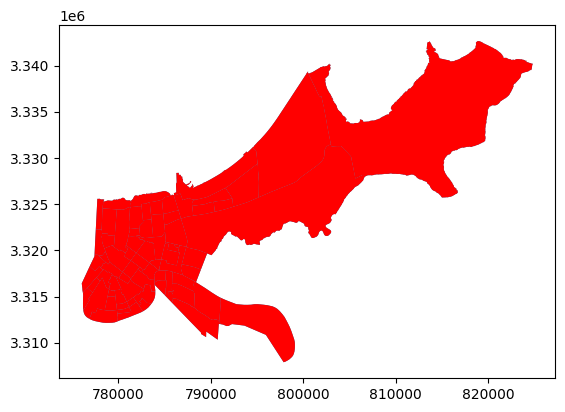

In [11]:
ax = neighborhoodDf.plot()
neighborhoodDf[captureHoodsMask].plot(ax=ax, color='red')

In [12]:
bounds = [int(b) for b in neighborhoodDf[captureHoodsMask].total_bounds]

In [13]:
xPixels = (bounds[2] - bounds[0]) / resolution
yPixels = (bounds[3] - bounds[1]) / resolution
lp(f"Resolution will be {xPixels} x {yPixels}  Runtime based on {xPixels*yPixels}")

[2025-03-29 03:10:26.568158] Resolution will be 488.07 x 347.58  Runtime based on 169643.3706


In [14]:
boxes = [shapely.box(x,y,x+resolution,y+resolution) for x, y in product(range(bounds[0], bounds[2], resolution), range(bounds[1], bounds[3], resolution))]
boxesDf = gpd.GeoDataFrame(geometry=boxes).set_crs(neighborhoodDf.crs)
boxesDf = boxesDf[boxesDf.intersects(neighborhoodDf[captureHoodsMask].union_all())].copy()
boxesDf['AltitudeTotal'] = np.nan
boxesDf['WaterTotal'] = np.nan
boxesDf['IntTotal'] = np.nan  #total intensity
boxesDf['Total'] = np.nan
boxesDf['RunTime'] = datetime.now()-datetime.now()
lp(f"Boxes count:  {boxesDf.shape[0]}")

[2025-03-29 03:11:12.346867] Boxes count:  55104


<Axes: >

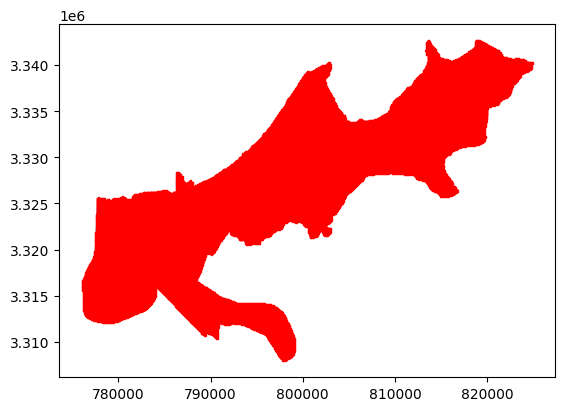

In [15]:
ax = neighborhoodDf.plot()
boxesDf.plot(edgecolor='red', color=None, ax=ax)

In [16]:
tileIndex = gpd.read_file(f"{dataPath}UpperDeltaPlainLATileIndex.shp").to_crs(neighborhoodDf.crs)
tileIndex.index = tileIndex['TILENAME'].map(lambda f: f"/home/ec2-user/notebooks/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_{f.lower()}.laz")
tileIndexBroadcast = sc.broadcast(tileIndex)
tileIndexBroadcast.value.head()

,TILENAME,geometry
TILENAME,,
/home/ec2-user/notebooks/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp545750.laz,15RYP545750,"POLYGON ((754500 3375000, 754500 3376500, 7560..."
/home/ec2-user/notebooks/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp560750.laz,15RYP560750,"POLYGON ((756000 3375000, 756000 3376500, 7575..."
/home/ec2-user/notebooks/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp575750.laz,15RYP575750,"POLYGON ((757500 3375000, 757500 3376500, 7590..."
/home/ec2-user/notebooks/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp590750.laz,15RYP590750,"POLYGON ((759000 3375000, 759000 3376500, 7605..."
/home/ec2-user/notebooks/NewOrleansElevation/datasets/lazUpperDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15ryp605750.laz,15RYP605750,"POLYGON ((760500 3375000, 760500 3376500, 7620..."


In [17]:
wgsToUTM = pyproj.transformer.Transformer.from_crs(crs_from=pyproj.CRS.from_string('WGS84'), crs_to=neighborhoodDf.crs)
meridianReg = re.compile(r'PARAMETER\["central_meridian",\-([0-9]{2})\]')


def processLas(inputTup):
    startTime = datetime.now()
    
    BoxIdx = inputTup[0]
    boxBounds = inputTup[1:]
    
    lp(f"Processing for box[{BoxIdx}] {boxBounds}")

    altTotal = 0
    waterTotal = 0
    intTotal = 0
    pointTotal = 0
    for idx, row in tileIndexBroadcast.value.iterrows():
        if not row['geometry'].intersects(shapely.box(*boxBounds)):
            #no intersection scip
            continue
        
        try:        
            las = laspy.read(idx)
        except FileNotFoundError as e:
            lp(f"path {idx} does not exist skipping" )
            continue
            
        
        
        central_meridian = int(meridianReg.findall(las.header.vlrs[0].string)[0]) * -1
    
        
        X = las.X
        Y = las.Y
        Z = las.Z
        intense = las.intensity
        cls = las.classification
    
        groundMask = np.isin(cls, [2,9])
        inBoundsMaskX = np.logical_and(X >= (boxBounds[0]*100), (X <= (boxBounds[2]*100)))
        inBoundsMaskY = np.logical_and(Y >= (boxBounds[1]*100), (Y <= (boxBounds[3]*100)))
        goodPointMask = np.logical_and(groundMask,inBoundsMaskX,inBoundsMaskY)
        
        x = X[goodPointMask]/100.0 #- bounds[0]
        y = (Y[goodPointMask]/100.0 + wgsToUTM.transform(30,central_meridian)[1]) #- bounds[1]
 
        altTotal += int(Z[goodPointMask].sum())
        waterTotal += np.count_nonzero(cls[goodPointMask] == 9)
        intTotal += int(intense[goodPointMask].sum())
        pointTotal += np.count_nonzero(goodPointMask)

    return (BoxIdx,altTotal, waterTotal, intTotal, pointTotal, datetime.now() - startTime)


In [18]:
#Just for sanity
testIdx = 1
processLas(list(boxesDf.bounds.itertuples())[testIdx])

[2025-03-29 03:11:19.958868] Processing for box[77] (776039.0, 3315588.0, 776139.0, 3315688.0)


(77,
 40046432,
 316060,
 2953312383,
 316060,
 datetime.timedelta(seconds=1, microseconds=464703))

In [19]:
boxesRdd = sc.parallelize(boxesDf.bounds.itertuples(), 5000)

In [20]:
boxesProcessedRdd = boxesRdd.map(processLas)

In [21]:
lp(f"{boxesDf.shape[0]} boxes total")

[2025-03-29 03:11:23.355877] 55104 boxes total


In [22]:
output = boxesProcessedRdd.collect()

In [23]:
boxesDf.columns

Index(['geometry', 'AltitudeTotal', 'WaterTotal', 'IntTotal', 'Total',
       'RunTime'],
      dtype='object')

In [24]:
for out in output:
    boxesDf.loc[out[0], 'AltitudeTotal'] = out[1]
    boxesDf.loc[out[0], 'WaterTotal'] = out[2]
    boxesDf.loc[out[0], 'IntTotal'] = out[3]
    boxesDf.loc[out[0], 'Total'] = out[4]
    boxesDf.loc[out[0], 'RunTime'] = out[5]

In [25]:
lp(f"{boxesDf['RunTime'].mean()} avg runtime\t\ttotal:  {boxesDf['RunTime'].sum()}")

[2025-03-29 03:24:15.087149] 0 days 00:00:05.961984 avg runtime		total:  3 days 19:15:29.213422


In [26]:
boxesDf.head()

,geometry,AltitudeTotal,WaterTotal,IntTotal,Total,RunTime
76,"POLYGON ((776139 3315488, 776139 3315588, 7760...",40046432.0,316060.0,2.953312e+09,316060.0,0 days 00:00:27.795515
77,"POLYGON ((776139 3315588, 776139 3315688, 7760...",40046432.0,316060.0,2.953312e+09,316060.0,0 days 00:00:07.462442
78,"POLYGON ((776139 3315688, 776139 3315788, 7760...",40046432.0,316060.0,2.953312e+09,316060.0,0 days 00:00:06.245065
79,"POLYGON ((776139 3315788, 776139 3315888, 7760...",40046432.0,316060.0,2.953312e+09,316060.0,0 days 00:00:08.862301
80,"POLYGON ((776139 3315888, 776139 3315988, 7760...",40046432.0,316060.0,2.953312e+09,316060.0,0 days 00:00:06.173404


In [27]:
boxesDf.to_pickle(outputFileName)

In [28]:
with open(f"{outPath}FinishTime_UpperDelta_{resolution}m.txt", 'w') as f:
    f.write(f"Finished shape {boxesDf.shape}  stop time {datetime.now()}")

<Axes: >

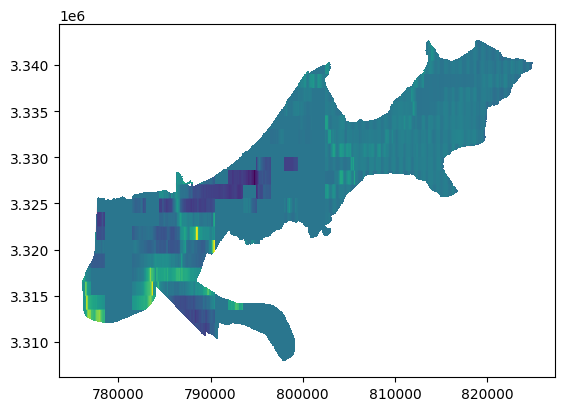

In [29]:
boxesDf['AltCalc'] = boxesDf['AltitudeTotal'] / boxesDf['Total'] 
boxesDf.loc[pd.isna(boxesDf['AltCalc']),'AltCalc'] = 0
ax = neighborhoodDf.plot(color='pink')
boxesDf.plot(column='AltCalc',ax=ax)

In [30]:
boxesDf.describe()

,AltitudeTotal,WaterTotal,IntTotal,Total,RunTime,AltCalc
count,5.510400e+04,55104.000000,5.510400e+04,55104.000000,55104,55104.000000
mean,-7.510300e+05,20923.917411,1.233452e+09,134094.887032,0 days 00:00:05.961984,6.506341
std,2.324214e+07,44125.015893,1.481481e+09,129638.330415,0 days 00:00:03.241040,86.311280
min,-1.822766e+08,0.000000,0.000000e+00,0.000000,0 days 00:00:00.678672,-403.942623
25%,0.000000e+00,0.000000,0.000000e+00,0.000000,0 days 00:00:04.196803,0.000000
50%,0.000000e+00,402.000000,8.017261e+08,126434.000000,0 days 00:00:05.457803,0.000000
75%,3.916123e+06,17153.000000,1.941252e+09,218447.000000,0 days 00:00:06.998203,29.933265
max,3.284757e+08,539689.000000,1.419333e+10,967832.000000,0 days 00:00:43.710327,623.887508


In [31]:
lp(f"total unit runtime: {boxesDf['RunTime'].sum()}")

[2025-03-29 03:24:22.260316] total unit runtime: 3 days 19:15:29.213422


In [32]:
lp("Done!")

[2025-03-29 03:24:22.268108] Done!


In [ ]:
#the actual runs where don using ProcessLidar.py because of problems with connection issues and its effects on long running notebooks